# Explore Exercises

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_data

In [2]:
df = wrangle_data()

In [3]:
df.show(1, vertical = True)

-RECORD 0------------------------------------
 source_id            | svcCRMLS             
 dept_division        | Field Operations     
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 SLA_due_date         | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 request_address      | 2315  el paso st,... 
 council_district     | 5                    
 num_weeks_late       | -142.6441088         
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 source_username      | svcCRMLS  

## 1. How many different cases are there, by department?

Text(0.5, 0, 'Number of unique cases')

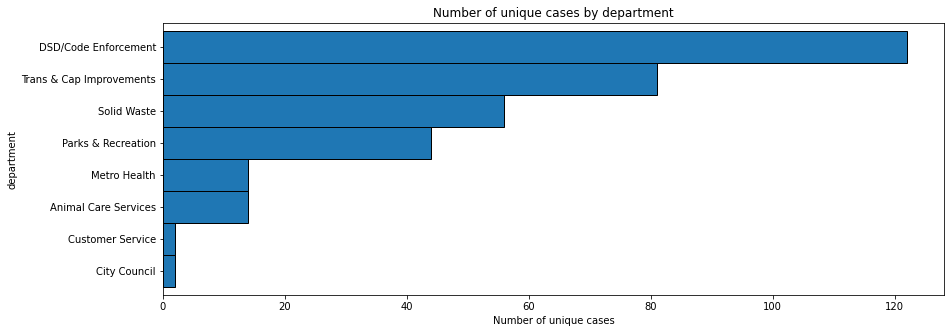

In [4]:
(
    df.groupBy("department", "service_request_type")
    .count()
    .toPandas()
    .groupby("department")
    .service_request_type
    .count()
    .sort_values()
    .plot.barh(width=1, edgecolor="black", figsize=(14,5))
    
)

plt.title("Number of unique cases by department")
plt.xlabel("Number of unique cases")

## 2. Does the percentage of cases that are late vary by department?

Text(0, 0.5, '% cases late')

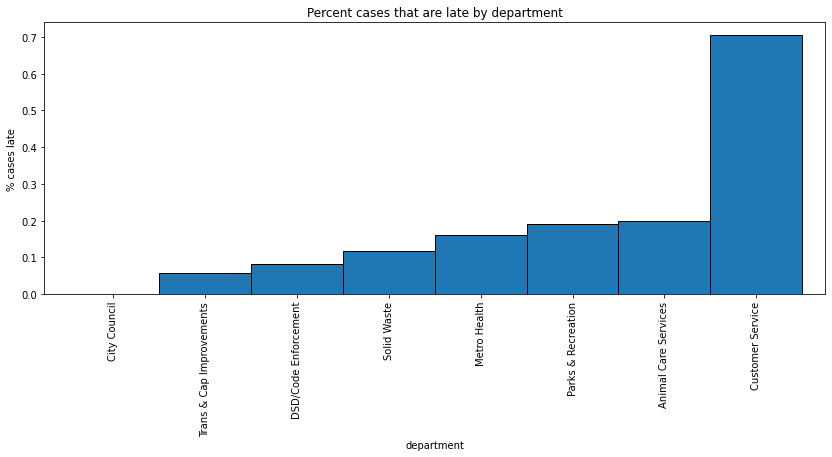

In [5]:
(
    df.select("department", "case_late")
    .toPandas()
    .groupby("department")
    .case_late
    .mean()
    .sort_values()
    .plot.bar(width=1, edgecolor="black", figsize=(14, 5))

)

plt.title("Percent cases that are late by department")
plt.ylabel("% cases late")

## 3. On average, how late are the late cases by department?

Text(0, 0.5, 'Number of Days')

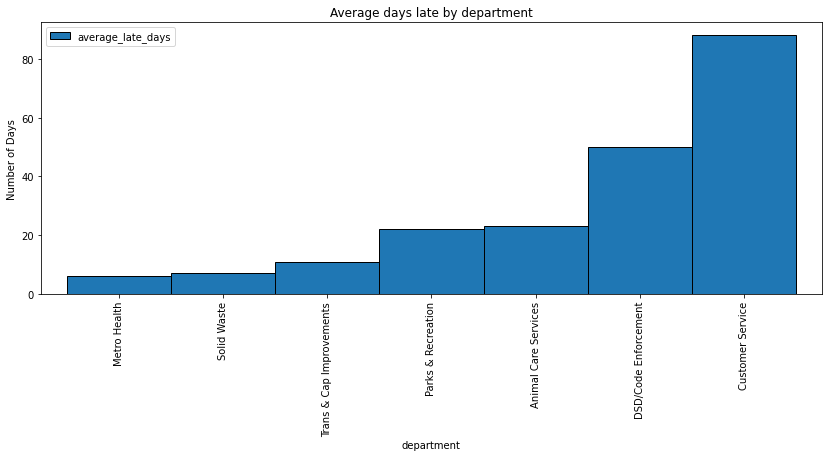

In [6]:
(
    df.filter(df.case_late == "true")
    .groupBy("department")
    .agg(round(mean("num_days_late"), 0).alias("average_late_days"))
    .toPandas()
    .sort_values(by="average_late_days")
    .set_index("department")
    .plot.bar(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Average days late by department")
plt.ylabel("Number of Days")

## 4. What is the service type that is the most late? Just for Parks & Rec?

In [7]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 source_id            | svcCRMLS             
 dept_division        | Field Operations     
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 SLA_due_date         | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 request_address      | 2315  el paso st,... 
 council_district     | 5                    
 num_weeks_late       | -142.6441088         
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 source_username      | svcCRMLS  

Text(0.5, 0, 'Type of Request')

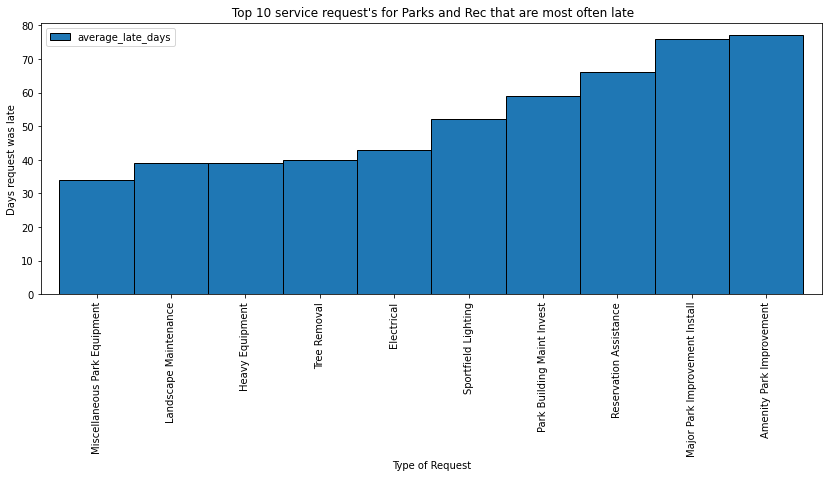

In [40]:
(
    df.filter(df.department == "Parks & Recreation")
    .filter(df.case_late == "true")
    .groupby("service_request_type")
    .agg(round(mean("num_days_late"), 0).alias("average_late_days"))
    .sort("average_late_days")
    .toPandas()
    .set_index("service_request_type")
    .tail(10)
    .plot.bar(width=1, edgecolor="black", figsize=(14, 5))


)

plt.title(" Top 10 service request's for Parks and Rec that are most often late")
plt.ylabel("Days request was late")
plt.xlabel("Type of Request")

## 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [9]:
department_list = (
    df.select(df.department)
    .toPandas()
    .department
    .unique()
)

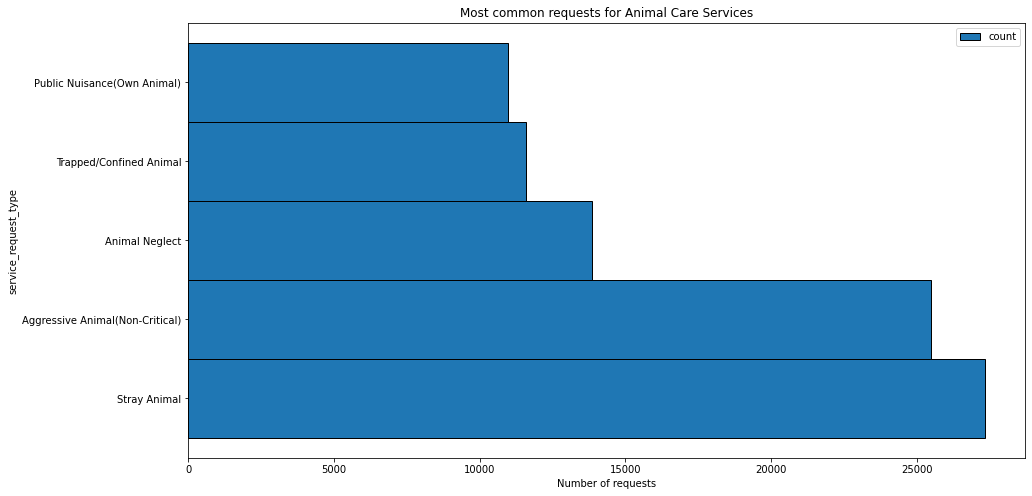

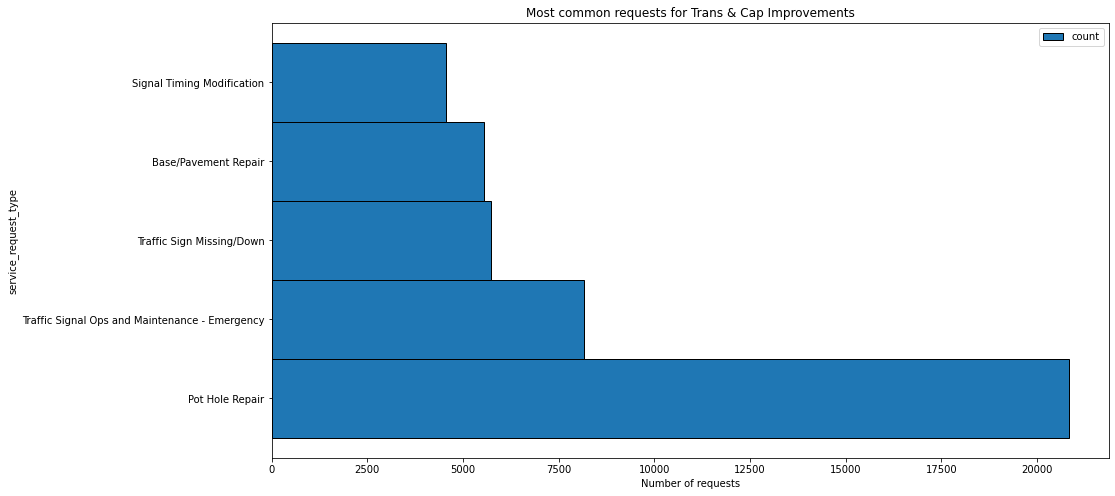

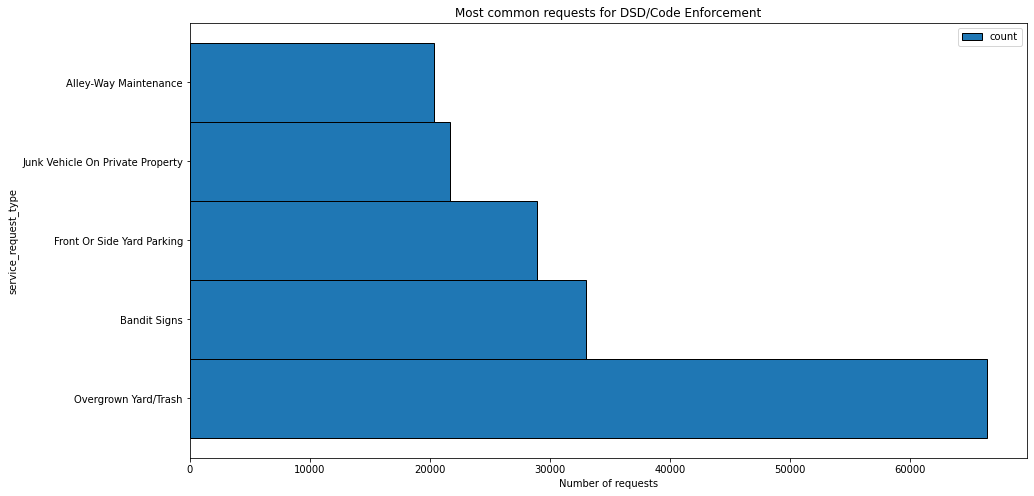

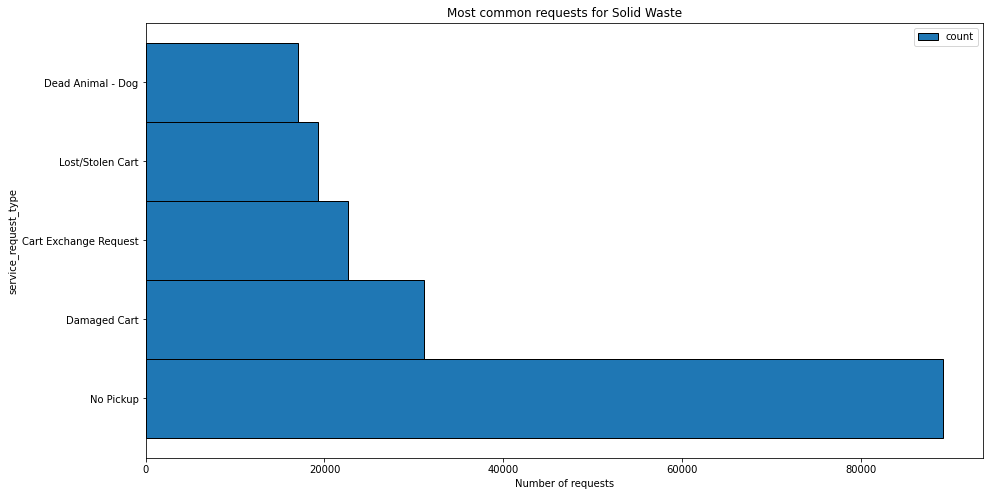

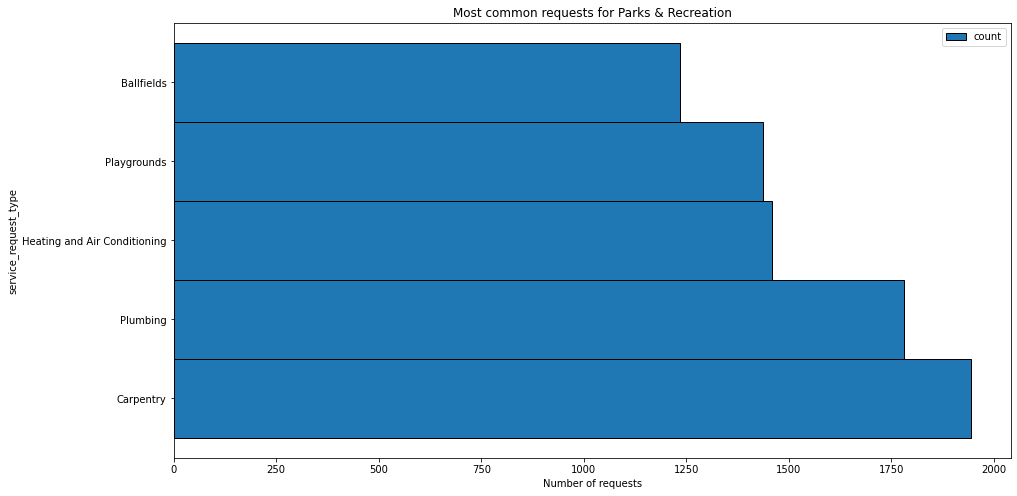

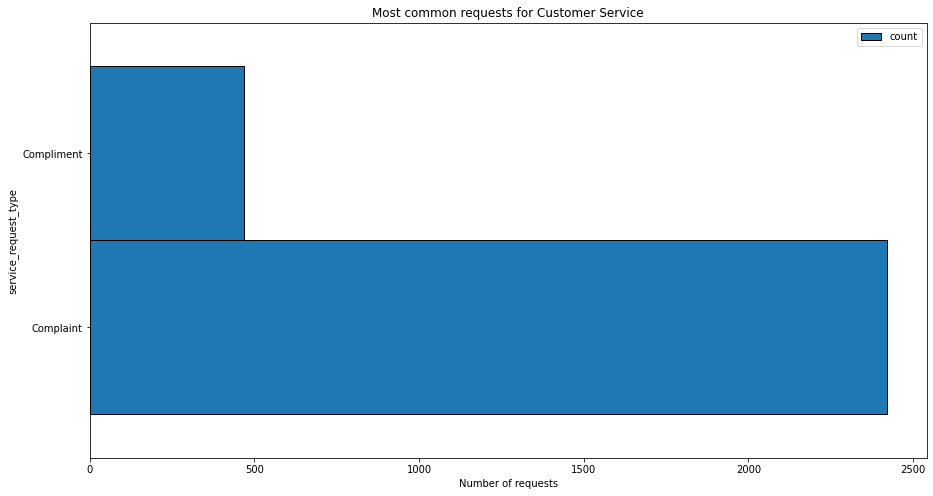

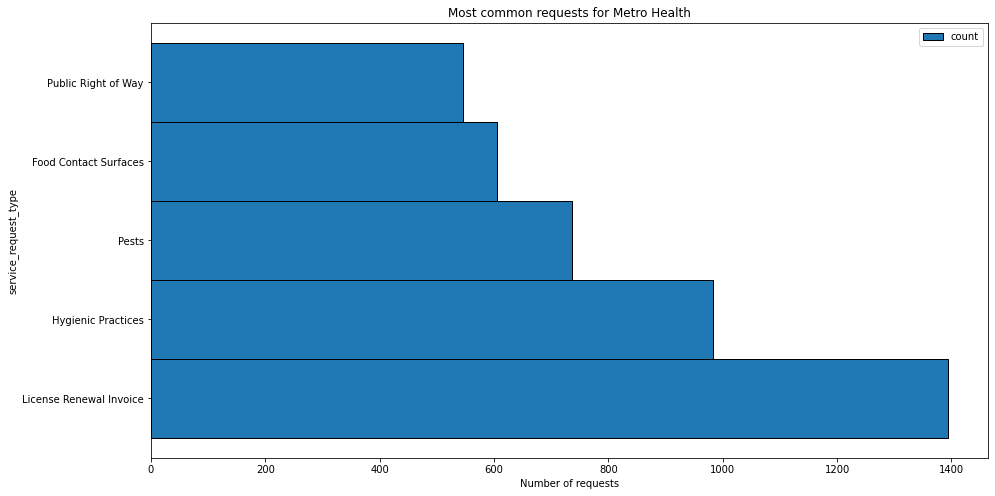

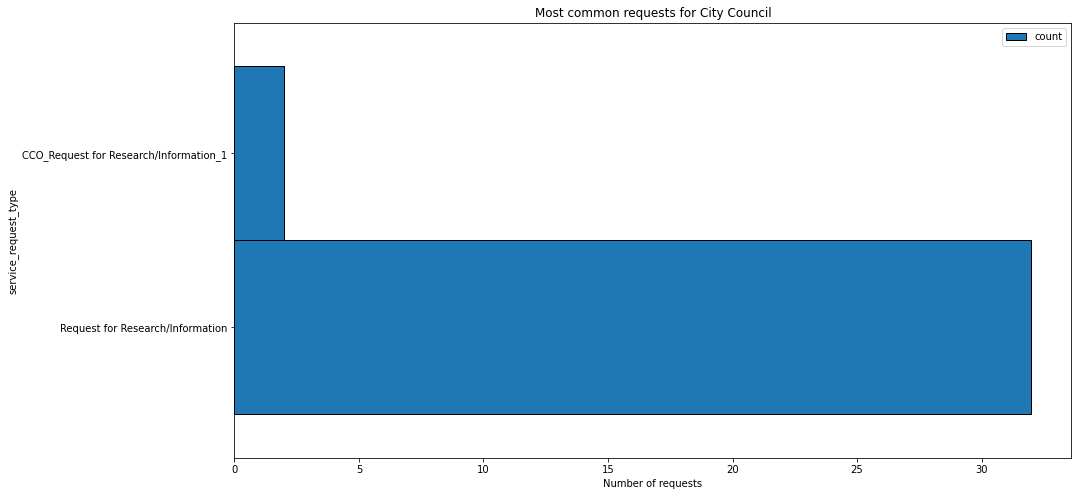

In [10]:
for i in range(department_list.shape[0]):

    (

        df.filter(df.department == department_list[i])
        .groupby("service_request_type")
        .count()
        .sort(col("count").desc())
        .toPandas()
        .head(5)
        .set_index("service_request_type")
        .plot.barh(width=1, edgecolor="black", figsize=(15, 8))
    )

    plt.title(f"Most common requests for {department_list[i]}")
    plt.xlabel("Number of requests")

## 6. Does whether or not its a weekend matter for when a case is opened/closed?

In [11]:
cases_by_day = (
    df.select(
        date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
        date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
    )
   
)

In [12]:
cases_by_day

DataFrame[case_opened_date: string, case_closed_date: string]

In [13]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'

In [14]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [15]:
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
ts.head(5)

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1443,390
2017-01-03,1813,757
2017-01-04,1647,1247
2017-01-05,1841,1199


In [16]:
ts["day_of_week"] = ts.index.day_name()

Text(0.5, 0.98, 'Do cases get opened/closed on the weekends?')

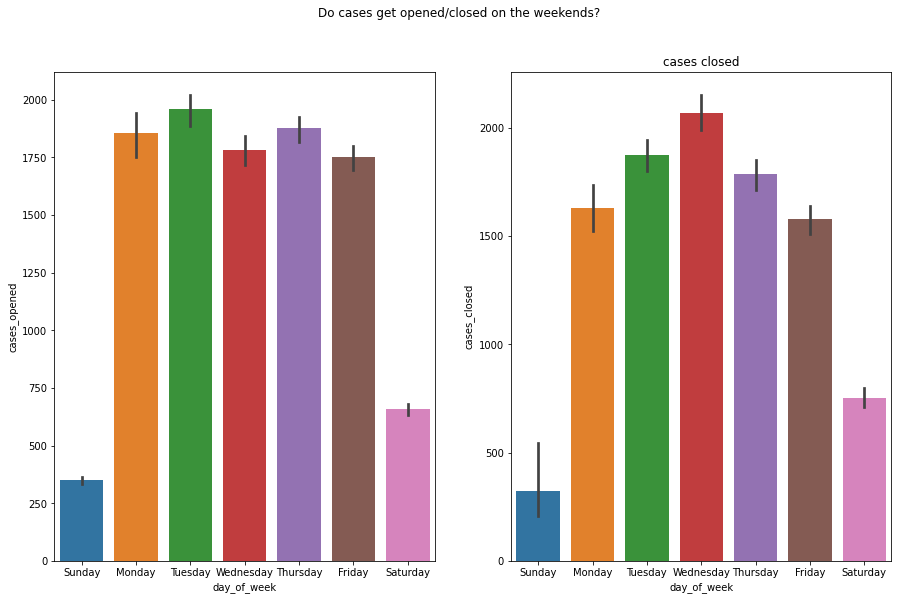

In [17]:
f, axes = plt.subplots(1,2, figsize=(15, 9))

sns.barplot(data=ts, x="day_of_week", y="cases_opened", ax=axes[0])
plt.title("cases opened")
sns.barplot(data=ts, x="day_of_week", y="cases_closed", ax=axes[1])
plt.title("cases closed")

plt.suptitle("Do cases get opened/closed on the weekends?")

# It seems that cases do still get opened/closed on the weekends, but
# at a much smaller rate

## 7.On average, how many cases are opened a day for the Customer Service department?

In [18]:
cases_by_day = (
    df.filter(df.department == "Customer Service")
    .select(date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"))
    


)

In [19]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'

In [20]:
print(f"About {cases_opened_by_day.mean():.0f} cases are open per day for the Customer Service team")

About 6 cases are open per day for the Customer Service team


## 8.Does the number of service requests for the solid waste department vary by day of the week?

In [21]:
cases_by_day = (
    df.filter(df.department == "Solid Waste")
    .select(date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"))
    


)

In [22]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'

In [23]:
ts = pd.DataFrame(cases_opened_by_day)

In [24]:
ts

,cases_opened
case_opened_date,
2017-01-01,43
2017-01-02,751
2017-01-03,812
2017-01-04,554
2017-01-05,618
...,...
2018-08-04,180
2018-08-05,100
2018-08-06,794


In [25]:
ts["week_day"] = ts.index.day_name()

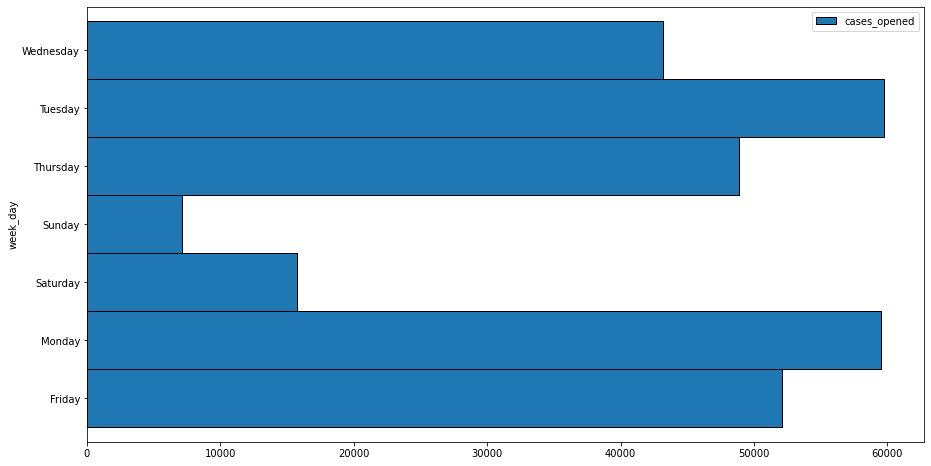

In [26]:
ts.groupby("week_day").sum().plot.barh(width=1, edgecolor="black", figsize=(15, 8))

## Bonus... about them used mattress

Text(0.5, 0, 'N of calls')

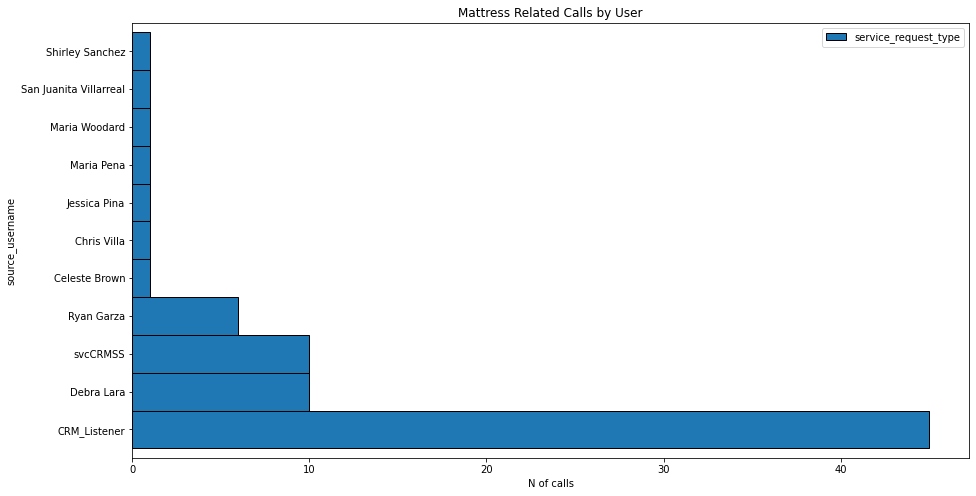

In [38]:
# What user has had the most "mattress related calls
(
    df.filter(df.service_request_type.contains("Mattress"))
    .select(df.service_request_type, df.source_username)
    .toPandas()
    .groupby("source_username")
    .count()
    .sort_values(by="service_request_type", ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(15, 8))
        
    
)

plt.title("Mattress Related Calls by User")
plt.xlabel("N of calls")

In [52]:
# What days are mattress related calls more likely to happen?

ts = (
    df.filter(df.service_request_type.contains("Mattress"))
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    
)

In [54]:
ts.index.day_name()

Index(['Monday', 'Wednesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Friday', 'Wednesday',
       'Wednesday', 'Wednesday', 'Wednesday', 'Friday', 'Monday', 'Monday',
       'Monday', 'Tuesday', 'Tuesday', 'Sunday', 'Monday', 'Thursday',
       'Monday', 'Friday', 'Tuesday', 'Thursday', 'Thursday', 'Thursday',
       'Friday', 'Tuesday', 'Friday', 'Tuesday', 'Thursday', 'Thursday',
       'Tuesday', 'Friday', 'Friday', 'Thursday', 'Friday', 'Friday', 'Friday',
       'Tuesday', 'Thursday', 'Wednesday', 'Friday'],
      dtype='object', name='case_opened_date')

In [53]:
ts.head()

,count
case_opened_date,
2017-01-09 10:18:00,1
2017-01-25 11:16:00,1
2017-01-31 08:48:00,1
2017-01-31 08:53:00,1
2017-01-31 08:58:00,1
